# Register H&E image and IF image

Tutorial on color deconvolution: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_ihc_color_separation.html

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2hed, hed2rgb
import gc

In [4]:
from skimage.io import imread, imsave
from pathlib import Path

## Load images

In [5]:
he_path = Path(r"D:\data\37_56-HE_and_IF\HPC_Wirth_Kidney_TS26_HE_L1\HPC_Wirth_Kidney_TS26_HE_L1_s2.tif")
dapi_path = Path(r"D:\data\37_56-HE_and_IF\HPC_Wirth_Kidney_TS26_CD31-555_L1\HPC_Wirth_Kidney_TS26_CD31-555_L1_s2c1_ORG.tif")

In [6]:
he_img = imread(he_path)

In [7]:
dapi_img = imread(dapi_path)

In [8]:
he_img.shape

(29110, 24298, 3)

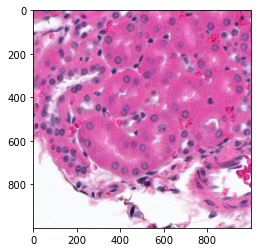

In [9]:
plt.imshow(db.im.crop_center(he_img, (10000, 10000), 1000))

In [10]:
dapi_img.shape

(14962, 12337)

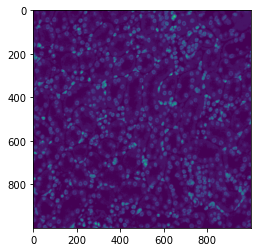

In [11]:
plt.imshow(db.im.crop_center(dapi_img, (5000, 5000), 1000))

## Deconvolve H&E image

### Test on cropped image

In [12]:
crop = db.im.crop_center(he_img, center=(12000, 10000), width=1000)

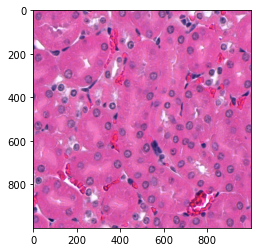

In [13]:
plt.imshow(crop)

In [14]:
decon = db.im.deconvolve_he(img=crop, return_type="grayscale")

In [15]:
hema = decon[:, :, 0]

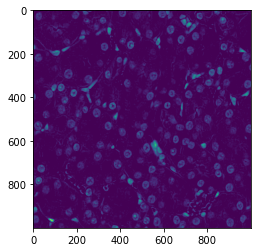

In [16]:
plt.imshow(hema)

In [17]:
hema, eosin, _ = db.im.deconvolve_he(img=crop, return_type="rgb")

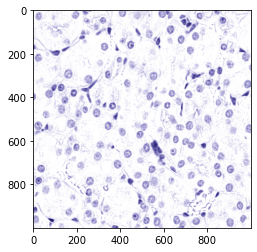

In [18]:
plt.imshow(hema)

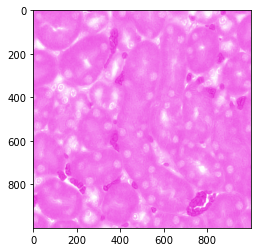

In [19]:
plt.imshow(eosin)

### Reduce image size to deconvolve the whole image

The images are too big to be processed on normal sized RAM. Therefore I need to scale them before processing.

In [20]:
he_scaled = db.im.resize_image(he_img, scale_factor=0.5)

In [21]:
he_scaled.shape

(14555, 12149, 3)

In [22]:
decon = db.im.deconvolve_he(img=he_scaled, return_type="grayscale")

In [23]:
# extract hematoxylin channel and convert to 8-bit
hema = decon[:, :, 0]
hema = hema / hema.max() * 255
hema = hema.astype(int)

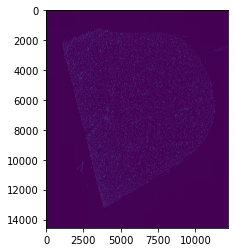

In [24]:
plt.imshow(hema)

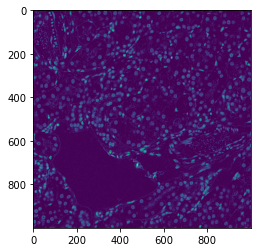

In [25]:
plt.imshow(db.im.crop_center(hema, (5000, 5000), 1000))

In [26]:
hema.shape

(14555, 12149)

## Do registration

In [27]:
registered_img, H, matchedVis = db.im.register_image(image=hema, template=dapi_img, maxpx=4000, perspective_transform=False)

Rescale image to following dimensions: (4000, 3338)
Rescale template to following dimensions: (4000, 3298)
Dim of image: (3338, 4000)
Dim of template: (3298, 4000)
Convert scaled images to 8 bit
2022-12-14 15:24:00: Get features...
     Method: SIFT...
2022-12-14 15:24:05: Compute matches...
2022-12-14 15:24:08: Filter matches...
2022-12-14 15:24:08: Display matches...
2022-12-14 15:24:09: Fetch keypoints...
2022-12-14 15:24:09: Estimate 2D affine transformation matrix...
2022-12-14 15:24:09: Register image by affine transformation...


In [34]:
db.im.set_histogram(hema, lower=0, upper=50)

255

In [46]:
hema.max()

255

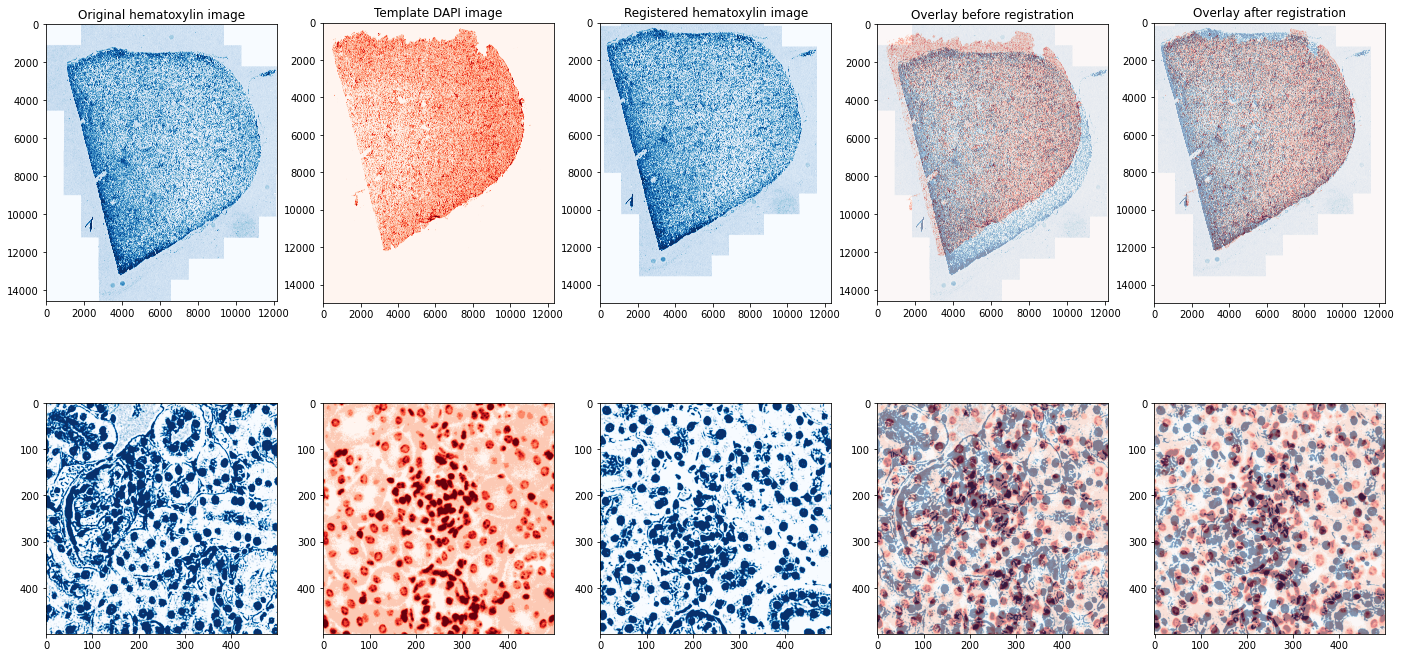

In [55]:
scale_factor = 1
titles = ['Original hematoxylin image', 'Template DAPI image', 'Registered hematoxylin image', 'Overlay before registration', 'Overlay after registration']
width = 500
lower=0
upper=5

fig, axs = plt.subplots(2, 5, figsize=(8*3, 6*2))

# resize images
hema_resized = db.im.resize_image(db.im.set_histogram(hema, lower=lower, upper=upper), scale_factor=scale_factor)
dapi_resized = db.im.resize_image(db.im.set_histogram(dapi_img, lower=lower, upper=upper), scale_factor=scale_factor)
reg_resized = db.im.resize_image(db.im.set_histogram(registered_img, lower=lower, upper=upper), scale_factor=scale_factor)

# calculate center for zoom-in
center = (int(reg_resized.shape[0] / 2), int(reg_resized.shape[1] / 2))

# do plotting
axs[0, 0].imshow(hema_resized, cmap="Blues", alpha=1)
axs[0, 1].imshow(dapi_resized, cmap="Reds", alpha=1)
axs[0, 2].imshow(reg_resized, cmap="Blues", alpha=1)
axs[0, 3].imshow(dapi_resized, cmap="Reds", alpha=1)
axs[0, 3].imshow(hema_resized, cmap="Blues", alpha=0.5)
axs[0, 4].imshow(dapi_resized, cmap="Reds", alpha=1)
axs[0, 4].imshow(reg_resized, cmap="Blues", alpha=0.5)

axs[1, 0].imshow(db.im.crop_center(hema_resized, center=center, width=width), cmap="Blues", alpha=1)
axs[1, 1].imshow(db.im.crop_center(dapi_resized, center=center, width=width), cmap="Reds", alpha=1)
axs[1, 2].imshow(db.im.crop_center(reg_resized, center=center, width=width), cmap="Blues", alpha=1)
axs[1, 3].imshow(db.im.crop_center(dapi_resized, center=center, width=width), cmap="Reds", alpha=1)
axs[1, 3].imshow(db.im.crop_center(hema_resized, center=center, width=width), cmap="Blues", alpha=0.5)
axs[1, 4].imshow(db.im.crop_center(dapi_resized, center=center, width=width), cmap="Reds", alpha=1)
axs[1, 4].imshow(db.im.crop_center(reg_resized, center=center, width=width), cmap="Blues", alpha=0.5)

for i, t in enumerate(titles):
    axs[0, i].set_title(t)

plt.savefig("figures/registration_HE_IF_comparisons.pdf", dpi=600)
plt.show()

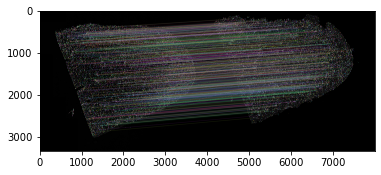

In [29]:
plt.imshow(matchedVis)
plt.savefig("figures/matchedVis_HE_IF.pdf", dpi=600)
plt.show()